# U.S Patent Phrase to Phrase Maching

## Sagemaker Setup

Firstly we will set up the basic sagemaker variables that we will use across the project. 

In [4]:
import boto3
import sagemaker
from sagemaker import get_execution_role

region = boto3.session.Session().region_name

session = sagemaker.Session()

role = get_execution_role()

## Import train data and EDA

Before starting with all the modelling, it is convinient to import and analyze the training data.

In [33]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/train.csv")
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


The exploratory data analysis will consist in visualizing the target variable frequencies and the "context" variable frequencies.

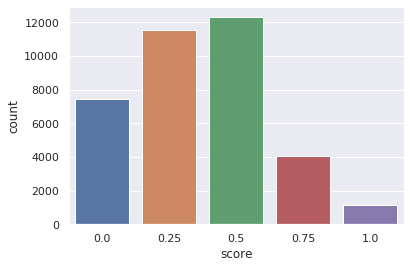

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt 
%matplotlib inline

sns.set(style="darkgrid")

sns.countplot(df.score)

Number of context categories:  106


C:\Users\kepa.oiartzun\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


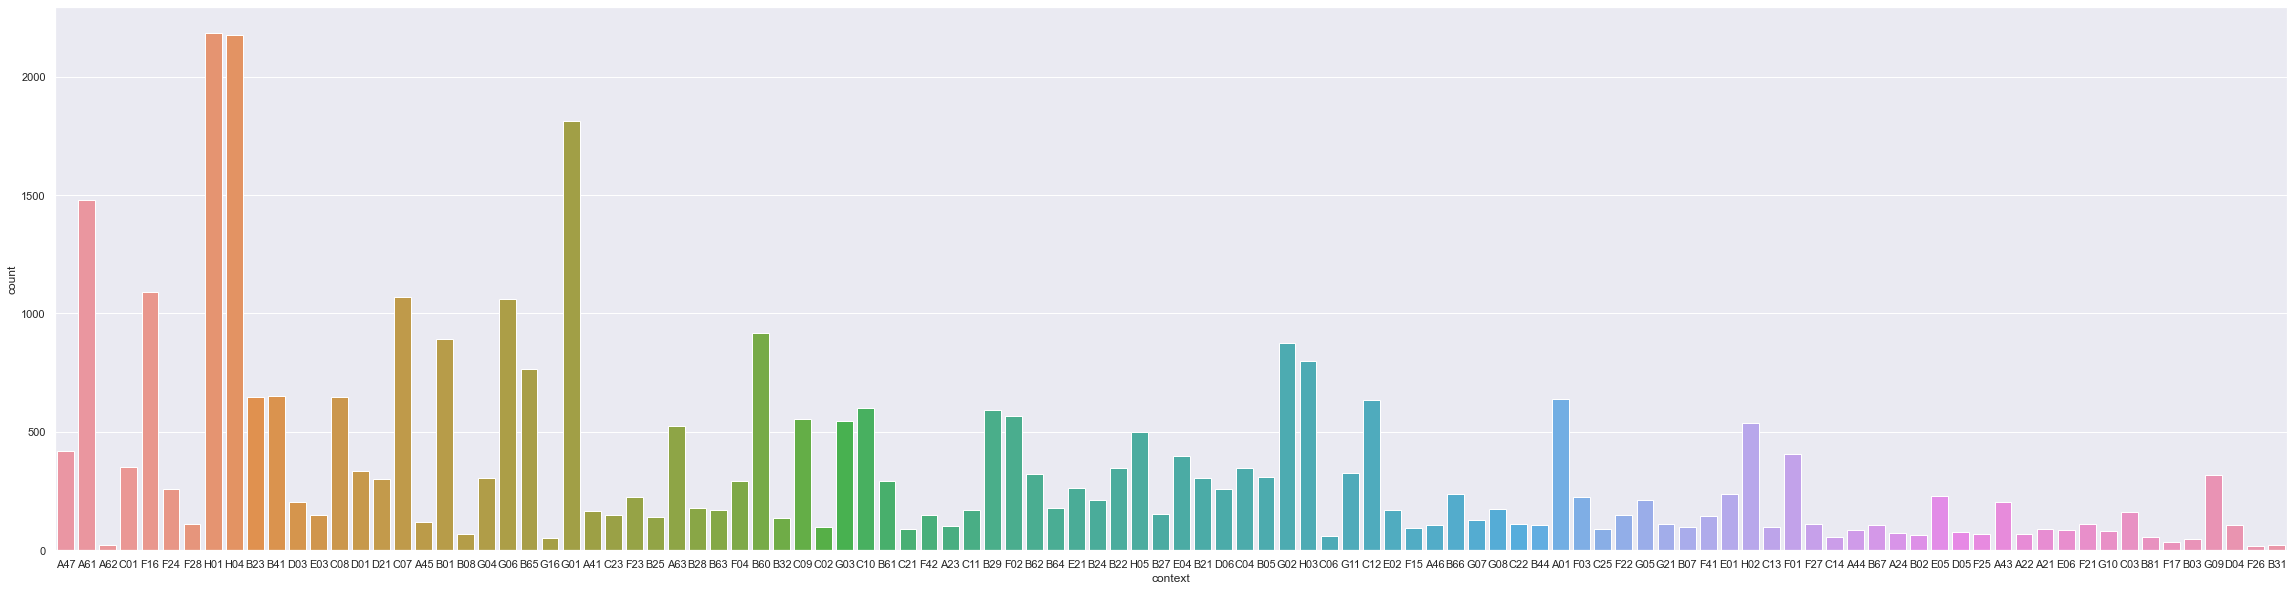

In [37]:
from matplotlib import pyplot as plt 

print("Number of context categories: ", len(df.context.unique()))

fig, (ax1) = plt.subplots(1, 1, figsize=(40,10))
sns.countplot(df.context, ax=ax1)
plt.show()

## Upload data to S3

The training data is going to be processed using a Sagemaker Processing Job, so firstly the data will be uploaded to S3.

In [ ]:
data_s3_path =  session.upload_data(path="data/train.csv", key_prefix="kaggle-patent-matching/data")
print("Data uploaded to: ", data_s3_path)

## Process data

For processing the data we will create a sagemaker processing job. This usually can be done by providing only a processing scrip, but in this case we are also going to bring a custom container. This is because we will use the SpaCy library to process the text, and it is not included in the default sagemaker processing containers.

https://docs.aws.amazon.com/sagemaker/latest/dg/processing-container-run-scripts.html

### Creating the processing script

The processing script has two objectives:
- **The context variable**, wich is going tho be processed using a Label Encoder.
- **The text variables** (anchor and target), which are going to be splited in tokens, and padded to a max of 40 tokens per text. Then, each token will be replaced by a vector that represents the token in a 300 dimension space. This all will be done using SpaCy.

It will also take an argument (--trainTestSplit) that determines if the data will be splited in train and test samples at processing. This is done because this processing script is going to be used to process both training and inference data.

In [45]:
%%writefile processing.py

import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import spacy
import os
from sklearn.model_selection import train_test_split
import argparse

nlp = spacy.load("en_core_web_md")

def preprocess_text(text, length):
    doc = nlp(text)
    seq = np.array([token for token in doc])
    if len(seq) >= length:
        seq = seq[:length]
    else:
        seq = np.pad(seq, (0,length-len(seq)), "constant", constant_values=(0, nlp('zero_vector')[0]))
    get_vectors = lambda x: x.vector
    return np.array(list(map(get_vectors, seq)))

if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--trainTestSplit', type=str, default="True")
    
    args, _ = parser.parse_known_args()
    print('Recieved arguments: {}'.format(args))

    input_data_path = os.path.join("/opt/ml/processing/input", "train.csv")
    print('Reading data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)

    le = LabelEncoder()
    df["context_encoded"] = le.fit_transform(df.context)
    
    trainTestSplit = args.trainTestSplit
    if trainTestSplit == "True":
        
        train, test = train_test_split(df, test_size=0.2, stratify=df.score)

        anchor_vectors_train = train.anchor.apply(lambda x: preprocess_text(x, 40))
        anchor_vectors_test = test.anchor.apply(lambda x: preprocess_text(x, 40))
        target_vectors_train = train.target.apply(lambda x: preprocess_text(x, 40))
        target_vectors_test = test.target.apply(lambda x: preprocess_text(x, 40))

        anchor_input_train = np.concatenate(anchor_vectors_train.values, axis=0).reshape(len(anchor_vectors_train), 40, 300)
        anchor_input_test = np.concatenate(anchor_vectors_test.values, axis=0).reshape(len(anchor_vectors_test), 40, 300)
        target_input_train = np.concatenate(target_vectors_train.values, axis=0).reshape(len(target_vectors_train), 40, 300)
        target_input_test = np.concatenate(target_vectors_test.values, axis=0).reshape(len(target_vectors_test), 40, 300)

        train.to_csv("/opt/ml/processing/output/processed_train.csv", index=False)
        np.save("/opt/ml/processing/output/anchor_input_train.npy", anchor_input_train)
        np.save("/opt/ml/processing/output/target_input_train.npy", target_input_train)

        test.to_csv("/opt/ml/processing/output/processed_test.csv", index=False)
        np.save("/opt/ml/processing/output/anchor_input_test.npy", anchor_input_test)
        np.save("/opt/ml/processing/output/target_input_test.npy", target_input_test)
    
    else: 
        
        anchor_vectors = df.anchor.apply(lambda x: preprocess_text(x, 40))
        target_vectors = df.target.apply(lambda x: preprocess_text(x, 40))
        
        anchor_input = np.concatenate(anchor_vectors.values, axis=0).reshape(len(anchor_vectors), 40, 300)
        target_input = np.concatenate(target_vectors.values, axis=0).reshape(len(target_vectors), 40, 300)
        
        df.to_csv("/opt/ml/processing/output/processed_data.csv")
        np.save("/opt/ml/processing/output/anchor_input.npy", anchor_input)
        np.save("/opt/ml/processing/output/target_input.npy", target_input)

Overwriting processing.py


### Creating the custom docker container

The docker container is going to be created from the dockerfile, and then it will be necessary to upload the docker image to the ECR. Here is the dockerfile used to create the container.

In [11]:
!mkdir docker

In [12]:
%%writefile docker/Dockerfile

FROM python:3.7-slim-buster

RUN pip3 install pandas scikit-learn numpy spacy
RUN python3 -m spacy download en_core_web_md

ENV PYTHONUNBUFFERED=TRUE

ENTRYPOINT ["python3"]

Writing docker/Dockerfile


### Run the processing job

The processing job can be run using the ScriptProcessor function, and providing both the processing script and the custom image uri.

To run the job it will be also necessary to configure its ProcessingInput and ProcessingOutput.

In [3]:
# The image uri of the image uploaded to ECR.

image_uri = 'image_uri'

In [ ]:
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput

script_processor = ScriptProcessor(command=['python3'],
                image_uri=image_uri,
                role=role,
                instance_count=1,
                instance_type='ml.m5.xlarge')

script_processor.run(
    code = 'processing.py',
    inputs=[ProcessingInput(source=data_s3_path, destination="/opt/ml/processing/input")],
    outputs=[ProcessingOutput(output_name="data_processed", source="/opt/ml/processing/output")]
)

preprocessing_job_description = script_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "data_processed":
        preprocessed_data_uri = output["S3Output"]["S3Uri"]
        
print("Preprocessed data uri: ", preprocessed_data_uri)

## Train a Tensorflow model using a script

We will train a custom model using tensorflow, so we will bring our own training script, and use sagemakers Tensorflow estimator to run the script and train the model.

Example: https://towardsdatascience.com/train-a-tensorflow-model-in-amazon-sagemaker-e2df9b036a8

### Creating the training script

The model will have the following design:

![model_architecture](images/model_architecture.PNG)

This model is going to be trained using the previously processed data (stored in S3), and the model itself will be saved in S3. The model is also going to be evaluated using the mean squared error, the mean average error, the max error and the pearson correlation.

In [8]:
%%writefile train.py

import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import json

def create_compiled_model(summary=True):
    # Defining model
    input_anchor = tf.keras.layers.Input(shape=(40, 300), name="input_anchor")
    # lstm_anchor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu", return_sequences=True))(input_anchor)
    # lstm_anchor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation="relu", return_sequences=True))(lstm_anchor)
    # lstm_anchor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation="relu", return_sequences=True))(lstm_anchor)
    # lstm_anchor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu"))(lstm_anchor)
    
    lstm_anchor = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu"))(input_anchor)

    input_target = tf.keras.layers.Input(shape=(40, 300), name="input_target")
    # lstm_target = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu", return_sequences=True))(input_target)
    # lstm_target = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation="relu", return_sequences=True))(lstm_target)
    # lstm_target = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation="relu", return_sequences=True))(lstm_target)
    # lstm_target = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu"))(lstm_target)
    
    lstm_target = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation="relu"))(input_target)

    input_context = tf.keras.layers.Input(shape=(1,), name="input_context")
    embedding_context = tf.keras.layers.Embedding(input_dim=106+1, output_dim=10)(input_context)
    embedding_context = tf.keras.layers.Flatten()(embedding_context)

    x = tf.keras.layers.concatenate([(lstm_anchor), (lstm_target), (embedding_context)])
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_anchor, input_target, input_context], outputs=output)

    # Compiling model

    model.compile(loss="mae", optimizer="adam", metrics=["mean_absolute_error"])
    
    if summary:
        model.summary()
    
    return model

def load_data(base_dir):
    #Load train data
    train_df = pd.read_csv(os.path.join(base_dir, "processed_train.csv"))
    anchor_input_train = np.load(os.path.join(base_dir, "anchor_input_train.npy"))
    target_input_train = np.load(os.path.join(base_dir, "target_input_train.npy"))
    
    #Load test data
    test_df = pd.read_csv(os.path.join(base_dir, "processed_test.csv"))
    anchor_input_test = np.load(os.path.join(base_dir, "anchor_input_test.npy"))
    target_input_test = np.load(os.path.join(base_dir, "target_input_test.npy"))
    
    return train_df, anchor_input_train, target_input_train, test_df, anchor_input_test, target_input_test

def evaluate_model(values, predictions):
    from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, r2_score
    
    values = np.array(values)
    predictions = np.array(predictions)
    
    print('Mean squared error: ', mean_squared_error(values, predictions))
    print('Mean absolute error: ', mean_absolute_error(values, predictions))
    print('Max error: ', max_error(values, predictions))
    print("Pearson correlation: ", np.corrcoef(values, predictions)[0][1])

if __name__ == "__main__":
    #Parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_dir", type=str, default=os.environ.get("SM_CHANNEL_TRAINING"))
    # parser.add_argument("--sm-model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAINING"))
    # parser.add_argument("--hosts", type=str, default=json.loads(os.environ.get("SM_HOSTS")))
    # parser.add_argument("--current-host", type=str, default=os.environ.get("SM_CURRENT_HOST"))
    args, unknown = parser.parse_known_args()
    
    #Load data
    train_df, anchor_input_train, target_input_train, test_df, anchor_input_test, target_input_test = load_data(args.train)
    
    #Create and train the model
    model = create_compiled_model()
    
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=4, restore_best_weights=False)
    
    history = model.fit(
        x=[anchor_input_train, target_input_train, train_df.context_encoded],
        y=train_df.score,
        validation_data=([anchor_input_test, target_input_test, test_df.context_encoded], test_df.score),
        callbacks=[earlystopping],
        batch_size=512,
        epochs=20,
        verbose=0
    )
    
    predictions = pd.Series(model.predict([anchor_input_test, target_input_test, test_df.context_encoded]).reshape(-1), index=test_df.index)
    evaluate_model(test_df.score, predictions)
    
    model.save(os.path.join(args.model_dir, '1'), "model1.h5")
    

Overwriting train.py


### Training the model

The model is going to be trained providing the custom script to the sagemaker Tensorflow estimator. This will create a training job that is going tho be run in a single "ml.p3.2xlarge" instance. 

In this case, the default account service limit was exceded when using the "ml.p3.2xlarge" instance, so it was necessary to request an increase for that limit.

In [ ]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/regions-quotas.html

from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point="train.py",
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    framework_version="2.2",
    py_version="py37",
)
tf_estimator.fit("S3 Path")

## Inference

Now we need to make predictions in the test dataset.

In [36]:
# Firstly lets import and visualyze the test dataset

import pandas as pd

test = pd.read_csv("data/test.csv")
test

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


### Data processing

The inference data also needs to be processed to be used to make predictions, so we will use the processing script and image definded previously to create a processing job.

In [ ]:
# Upload data to S3
data_s3_path =  session.upload_data(path="data/test.csv", key_prefix="kaggle-patent-matching/inference")
print("Data uploaded to: ", data_s3_path)

In [ ]:
# Rename data in s3 (the processing script reads a file named train.csv)
!aws s3 cp s3://path/test.csv s3://path/train.csv

In [3]:
# The image uri of the image uploaded to ECR.
image_uri = 'image uri'

In [ ]:
# Process data to make predictions

from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput

script_processor = ScriptProcessor(command=['python3'],
                image_uri=image_uri,
                role=role,
                instance_count=1,
                instance_type='ml.m5.xlarge')

script_processor.run(
    code = 'processing.py',
    inputs=[ProcessingInput(source="s3://path-to-inference-data/train.csv", destination="/opt/ml/processing/input")],
    outputs=[ProcessingOutput(output_name="data_processed", source="/opt/ml/processing/output")],
    arguments=['--trainTestSplit', 'False']
)

preprocessing_job_description = script_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "data_processed":
        preprocessed_data_uri = output["S3Output"]["S3Uri"]
        
print("Preprocessed data uri: ", preprocessed_data_uri)

In [ ]:
# copy processed data to local

!mkdir inference_data
!aws s3 cp --recursive s3://path-to-processed-data/data_processed ./inference_data

### Endpoint Deployment

The model can be easily deployed using the deploy method, but we will import the model from S3 first (this has the advantage that if the local variable tf_estimator is lost, we can recreate it).

Example: https://youtu.be/ZgV894sQxSU  (min 20)

#### Step 1: Creating a tar.gz file from the model and uploading it to S3

In [12]:
!mkdir model

In [ ]:
# Downloading the model files from S3

!aws s3 cp --recursive s3://path-to-the-tensorflow-model/ ./model

In [14]:
# The assets directory is empty, so we are going to create it
!mkdir model/1/assets

In [9]:
# Create the model-tf.tar.gz file from the model directory (/model/1)
%%sh
cd model
tar cvfz model-tf.tar.gz 1

1/
1/.ipynb_checkpoints/
1/variables/
1/variables/variables.data-00000-of-00001
1/variables/variables.index
1/saved_model.pb
1/assets/


In [ ]:
# Upload the molel-tf.tar.gz file to S3

model_path = session.upload_data(path="model/model-tf.tar.gz", key_prefix="kaggle-patent-matching/models")

print(model_path)

#### Step 2: Recreate the model and deploy an inference endpoint with it

In [5]:
# Recreate the model using the model-tf.tar.gz file in S3

from sagemaker.tensorflow.model import TensorFlowModel

tf_model = TensorFlowModel(
    model_data=model_path,
    framework_version="2.2",
    role=role
)

In [6]:
# Deploy the model

from time import strftime, gmtime

tf_endpoint_name = "tf-{}-{}".format("patentMatch", strftime("%Y-%m-%d-%H-%M-%S", gmtime()))

tf_predictor = tf_model.deploy(
    endpoint_name=tf_endpoint_name,
    initial_instance_count=1,
    instance_type="ml.t2.medium"
)

print(tf_endpoint_name)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!tf-patentMatch-2022-05-17-06-51-06


### Making predictions

In [7]:
# Firstly, lets import the previously processed inference data

import pandas as pd
import numpy as np

test = pd.read_csv('inference_data/processed_data.csv')
anchor_input = np.load("inference_data/anchor_input.npy")
target_input = np.load("inference_data/target_input.npy")

print("anchor input shape: ", anchor_input.shape)
print("target input shape: ", target_input.shape)
test

anchor input shape:  (36, 40, 300)
target input shape:  (36, 40, 300)


,Unnamed: 0,id,anchor,target,context,context_encoded
0,0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,22
1,1,09e418c93a776564,adjust gas flow,altering gas flow,F23,20
2,2,36baf228038e314b,lower trunnion,lower locating,B60,7
3,3,1f37ead645e7f0c8,cap component,upper portion,D06,14
4,4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,27
5,5,474c874d0c07bd21,dry corn,dry corn starch,C12,12
6,6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11,24
7,7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23,6
8,8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10,11
9,9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02,17


In [17]:
# We the input will be a json with a tensorflow serving format
json_input = {"inputs":{"input_anchor":anchor_input.tolist(), "input_target":target_input.tolist(), "input_context":[float(i) for i in test.context_encoded]}}

# Making predictions
predictions = tf_predictor.predict(json_input)
predictions

{'outputs': [[0.31328091],
  [0.615649939],
  [0.193632662],
  [0.537418962],
  [0.0952958465],
  [0.461509049],
  [0.335514128],
  [0.0232436061],
  [0.262130767],
  [0.796674967],
  [0.127021968],
  [0.0488137603],
  [0.334621549],
  [0.825120568],
  [0.625404716],
  [0.479759812],
  [0.259388328],
  [0.209048361],
  [0.546055198],
  [0.490404576],
  [0.0516518056],
  [0.259851098],
  [0.247690767],
  [0.222837031],
  [0.500812173],
  [0.252488136],
  [0.0415049195],
  [0.0511778593],
  [0.0205176771],
  [0.731563449],
  [0.252214],
  [0.108159572],
  [0.822397172],
  [0.497724205],
  [0.199389502],
  [0.343472183]]}

In [27]:
# Lets create a the submission table with the predictions

test['score'] = list(map(lambda x: x[0], predictions["outputs"]))
test = test[['id', 'score']]
test

,id,score
0,4112d61851461f60,0.313281
1,09e418c93a776564,0.615650
2,36baf228038e314b,0.193633
3,1f37ead645e7f0c8,0.537419
4,71a5b6ad068d531f,0.095296
5,474c874d0c07bd21,0.461509
6,442c114ed5c4e3c9,0.335514
7,b8ae62ea5e1d8bdb,0.023244
8,faaddaf8fcba8a3f,0.262131
9,ae0262c02566d2ce,0.796675


In [28]:
# Finally, exporting the submission table

test.to_csv("submission.csv", index=False)